In [1]:

from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import copy

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    AutoConfig,
    DataCollatorForTokenClassification,
    DataCollatorWithPadding,
)

from datasets import load_dataset, load_metric
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# dslim/bert-base-NER

Here we will use the dslim/bert-base-NER from [Hugging Face](https://huggingface.co/dslim/bert-base-NER)

#### Description (12/08/2023):

bert-base-NER is a fine-tuned BERT model that is ready to use for Named Entity Recognition and achieves state-of-the-art performance for the NER task. It has been trained to recognize four types of entities: location (LOC), organizations (ORG), person (PER) and Miscellaneous (MISC).

Specifically, this model is a bert-base-cased model that was fine-tuned on the English version of the standard CoNLL-2003 Named Entity Recognition dataset.

If you'd like to use a larger BERT-large model fine-tuned on the same dataset, a bert-large-NER version is also available.

# Imports

In [2]:
raw_dataset = load_dataset("conll2003")
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [3]:
raw_dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

In [4]:
ner_tags = raw_dataset['train'].features['ner_tags'].feature.names
ner_tags

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [5]:
id2label = {i: t for i, t in enumerate(ner_tags)}
id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [6]:
label2id = {v: k for k, v in id2label.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [7]:
def getLabelsFromIds(ids: List[int]) -> List[str]:
    return [id2label[i] for i in ids]

In [8]:
print(raw_dataset['train']["tokens"][0])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


In [9]:
print(raw_dataset['train']["ner_tags"][0])

[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [10]:
# checkpoint = "distilbert-base-cased"
# checkpoint = "bert-base-cased"
checkpoint = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
idx_sample = 12

train_tokens_1 = raw_dataset['train']["tokens"][idx_sample]
train_ids_1 = raw_dataset['train']["ner_tags"][idx_sample]
train_labels_1 = getLabelsFromIds(train_ids_1)

train_tokens_1, train_labels_1, train_ids_1

(['Only',
  'France',
  'and',
  'Britain',
  'backed',
  'Fischler',
  "'s",
  'proposal',
  '.'],
 ['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O'],
 [0, 5, 0, 5, 0, 1, 0, 0, 0])

In [12]:
tokenizer(train_tokens_1, is_split_into_words=True)

{'input_ids': [101, 2809, 1699, 1105, 2855, 5534, 17355, 9022, 2879, 112, 188, 5835, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint)
model

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [14]:
model(**tokenizer(train_tokens_1, is_split_into_words=True, return_tensors="pt"))

TokenClassifierOutput(loss=None, logits=tensor([[[ 9.5828e+00, -6.4667e-01, -1.3385e+00, -1.5358e+00, -1.6767e+00,
          -1.0450e+00, -1.6500e+00, -1.8213e+00, -1.4247e+00],
         [ 1.0090e+01, -1.1097e+00, -2.1093e+00, -1.4258e+00, -2.2993e+00,
          -7.0930e-01, -1.7512e+00, -1.3490e+00, -1.4734e+00],
         [-1.0621e+00, -7.9250e-01, -2.0153e+00, -1.2071e+00, -2.1277e+00,
          -9.1472e-01, -1.5885e+00,  9.4517e+00, -1.3763e+00],
         [ 1.0456e+01, -1.4644e+00, -1.4813e+00, -2.1380e+00, -1.8386e+00,
          -1.6047e+00, -8.5966e-01, -1.6926e+00, -4.2258e-01],
         [-1.0920e+00, -1.0023e+00, -2.1120e+00, -1.0224e+00, -2.3138e+00,
          -8.8912e-01, -1.4438e+00,  9.3718e+00, -1.3413e+00],
         [ 1.1111e+01, -1.1315e+00, -1.2947e+00, -1.6207e+00, -1.7997e+00,
          -1.7465e+00, -1.1368e+00, -2.0893e+00, -1.3941e+00],
         [-5.5315e-01, -1.0234e+00, -2.4313e+00,  8.8249e+00, -1.3122e+00,
          -3.9986e-03, -2.6255e+00, -1.0581e+00, -1.9163e

In [15]:
ner = pipeline("ner", model=model, tokenizer=tokenizer)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [16]:
example = "My name is Wolfgang and I live in Berlin"

ner_results = ner(example)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


# distilbert-base-cased 

Here we will try fine-tunning the "distilbert-base-cased" by my own

In [17]:
checkpoint = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [18]:
config = AutoConfig.from_pretrained(checkpoint, num_labels=len(ner_tags))
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 28996
}

In [19]:
config.id2label = id2label
config.id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [20]:
config.label2id = label2id
config.label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [21]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)
model

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [22]:
def alignTargets(labels, word_ids):
    aligned_targets = []
    prev_id = None
    
    for w_id in word_ids:
        if w_id is None:
            aligned_targets.append(-100)
        elif w_id == prev_id and labels[w_id] in [1, 3, 5, 7]:
            aligned_targets.append(labels[w_id]+1)
        else:
            aligned_targets.append(labels[w_id])
        
        prev_id = w_id
        
    return aligned_targets

def tokenize_fn(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"], truncation=True, is_split_into_words=True
    )
    aligned_targets = []
    for i, tags in enumerate(batch["ner_tags"]):
        aligned_targets.append(alignTargets(tags, tokenized_inputs.word_ids(i)))

    tokenized_inputs["labels"] = aligned_targets
    return tokenized_inputs


In [23]:
tokenizer("This lamb is little", padding=True, return_tensors="pt")

{'input_ids': tensor([[  101,  1188,  2495, 12913,  1110,  1376,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [24]:
tokenize_fn(raw_dataset['train'][:1])

{'input_ids': [[101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]]}

In [25]:
tokenized_dataset = raw_dataset.map(
    tokenize_fn, batched=True, remove_columns=raw_dataset["train"].column_names
)
tokenized_dataset


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [26]:
training_args = TrainingArguments(
    "my_trainer",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    seed=42,
)

In [36]:
seqeval_metric = load_metric("seqeval")


def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)

    # need to compute accuracy, but only consider those when label != -100
    mask = labels != -100
    acc = np.sum(predictions == labels) / mask.sum()
    metrics = {"acc_bruno": acc}

    # remove the -100, convert the int label to str label name
    str_predictions = [
        [id2label[l] for l in label_arr if l != -100] for label_arr in labels
    ]
    # do the same for predictions, unless int label = -100
    str_labels = [
        [id2label[p] for l, p in zip(label_arr, pred_arr) if l != -100]
        for label_arr, pred_arr in zip(labels, predictions)
    ]
    seqeval = seqeval_metric.compute(predictions=str_predictions, references=str_labels)
    
    return {**metrics, **seqeval}


In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
)


In [38]:
trainer.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1317 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

{'eval_loss': 0.09782279282808304, 'eval_acc_bruno': 0.9826337787720021, 'eval_LOC': {'precision': 0.9559063690800218, 'recall': 0.9466307277628032, 'f1': 0.9512459371614301, 'number': 1855}, 'eval_MISC': {'precision': 0.8904555314533622, 'recall': 0.8446502057613169, 'f1': 0.866948257655755, 'number': 972}, 'eval_ORG': {'precision': 0.8881431767337807, 'recall': 0.9196911196911197, 'f1': 0.9036418816388467, 'number': 1295}, 'eval_PER': {'precision': 0.9712269272529859, 'recall': 0.9303172126885075, 'f1': 0.9503320053120851, 'number': 1923}, 'eval_overall_precision': 0.9352070010097611, 'eval_overall_recall': 0.9192721257237386, 'eval_overall_f1': 0.9271711020271961, 'eval_overall_accuracy': 0.9826337787720021, 'eval_runtime': 4.3955, 'eval_samples_per_second': 739.396, 'eval_steps_per_second': 23.206, 'epoch': 1.0}
{'loss': 0.0061, 'learning_rate': 3.1017463933181475e-05, 'epoch': 1.14}


  0%|          | 0/102 [00:00<?, ?it/s]

{'eval_loss': 0.08913149684667587, 'eval_acc_bruno': 0.9829722729145818, 'eval_LOC': {'precision': 0.9700598802395209, 'recall': 0.9339622641509434, 'f1': 0.9516688918558077, 'number': 1908}, 'eval_MISC': {'precision': 0.8709327548806941, 'recall': 0.8443743427970557, 'f1': 0.8574479444741057, 'number': 951}, 'eval_ORG': {'precision': 0.9172259507829977, 'recall': 0.8861671469740634, 'f1': 0.9014290949065592, 'number': 1388}, 'eval_PER': {'precision': 0.9625407166123778, 'recall': 0.936608557844691, 'f1': 0.9493975903614458, 'number': 1893}, 'eval_overall_precision': 0.9404240996297543, 'eval_overall_recall': 0.9100977198697069, 'eval_overall_f1': 0.9250124151630524, 'eval_overall_accuracy': 0.9829722729145818, 'eval_runtime': 4.4772, 'eval_samples_per_second': 725.9, 'eval_steps_per_second': 22.782, 'epoch': 2.0}
{'loss': 0.005, 'learning_rate': 1.2034927866362947e-05, 'epoch': 2.28}


  0%|          | 0/102 [00:00<?, ?it/s]

{'eval_loss': 0.089959517121315, 'eval_acc_bruno': 0.9844292694413375, 'eval_LOC': {'precision': 0.9602612955906369, 'recall': 0.9540292049756626, 'f1': 0.9571351058057516, 'number': 1849}, 'eval_MISC': {'precision': 0.8904555314533622, 'recall': 0.8481404958677686, 'f1': 0.8687830687830688, 'number': 968}, 'eval_ORG': {'precision': 0.9202087994034303, 'recall': 0.8948513415518492, 'f1': 0.9073529411764706, 'number': 1379}, 'eval_PER': {'precision': 0.9701411509229099, 'recall': 0.9435058078141499, 'f1': 0.9566381156316917, 'number': 1894}, 'eval_overall_precision': 0.9434533826994278, 'eval_overall_recall': 0.9205254515599344, 'eval_overall_f1': 0.9318484042553192, 'eval_overall_accuracy': 0.9844292694413375, 'eval_runtime': 4.7795, 'eval_samples_per_second': 679.984, 'eval_steps_per_second': 21.341, 'epoch': 3.0}
{'train_runtime': 205.4518, 'train_samples_per_second': 205.026, 'train_steps_per_second': 6.41, 'train_loss': 0.004931800638805671, 'epoch': 3.0}


TrainOutput(global_step=1317, training_loss=0.004931800638805671, metrics={'train_runtime': 205.4518, 'train_samples_per_second': 205.026, 'train_steps_per_second': 6.41, 'train_loss': 0.004931800638805671, 'epoch': 3.0})

In [39]:
!ls my_trainer

checkpoint-1317  checkpoint-2195  checkpoint-3073  checkpoint-439
checkpoint-1756  checkpoint-2634  checkpoint-3512  checkpoint-878


In [43]:
def evalCheckpoints(ckpt_path, checkpoints, trainer):
    columns = ["eval_overall_accuracy", "eval_overall_f1", "eval_loss"]
    results = pd.DataFrame(columns=columns, index=checkpoints)
    
    _device = trainer.model.device
    _config = trainer.model.config
    model = copy.deepcopy(trainer.model)
    
    for _ckpt in checkpoints:
        _model = AutoModelForTokenClassification.from_pretrained(
            ckpt_path + "/" + _ckpt, config=_config
        )
        trainer.model = _model.to(_device)
        result = {k: v for k, v in trainer.evaluate().items() if k in columns}
        results.loc[_ckpt] = result

    # Restore model
    trainer.model = model
    
    results.reset_index(inplace=True)
    results.rename(columns={"index": "checkpoint"}, inplace=True)
    print(results)
    
    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the evaluation results for accuracy and F1 score
    sn.lineplot(x="checkpoint", y="eval_overall_accuracy", data=results, label="Accuracy Score", ax=axes[0])
    sn.lineplot(x="checkpoint", y="eval_overall_f1", data=results, label="F1 Score", ax=axes[0])
    axes[0].set_title("Evaluation Metrics")

    # Plot the evaluation results for loss
    sn.lineplot(x="checkpoint", y="eval_loss", data=results, ax=axes[1])
    axes[1].set_title("Evaluation Loss")

    # Adjust layout spacing
    plt.tight_layout()
    
    plt.show()


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

        checkpoint eval_overall_accuracy eval_overall_f1 eval_loss
0   checkpoint-439              0.982634        0.927171  0.097823
1   checkpoint-878              0.982972        0.925012  0.089131
2  checkpoint-1317              0.984429        0.931848   0.08996


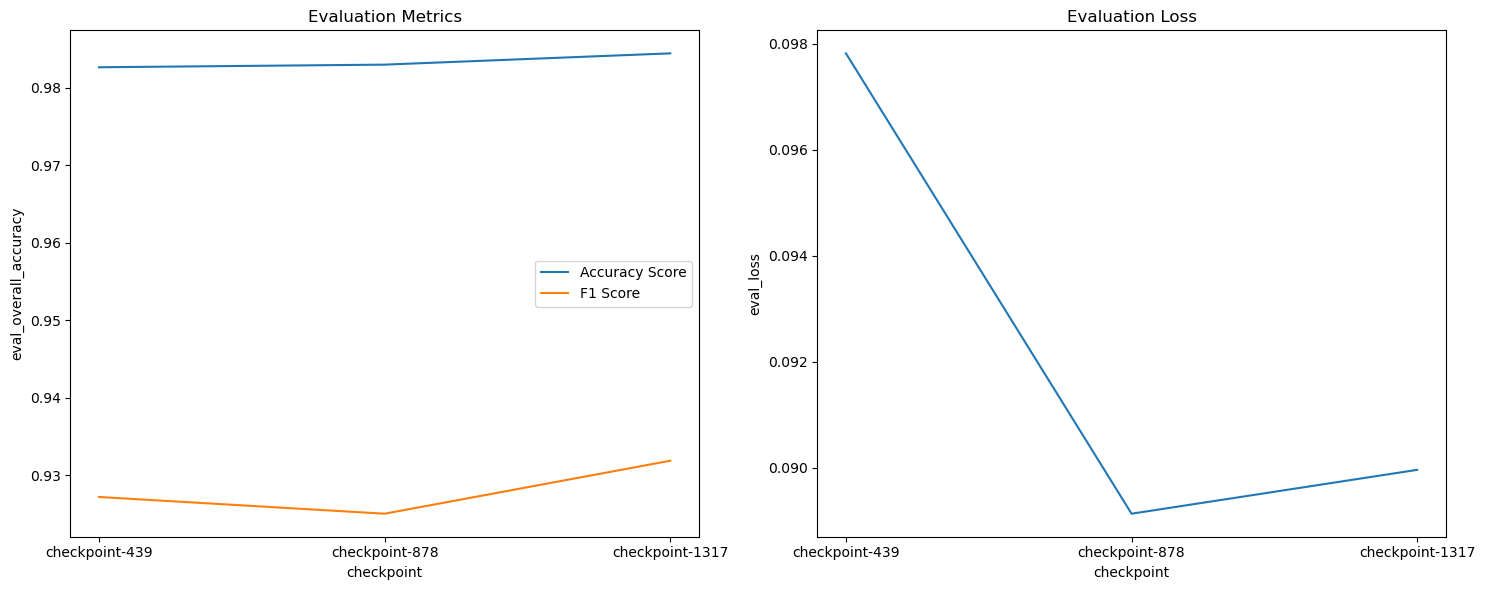

In [44]:
evalCheckpoints(
    "my_trainer",
    [
        "checkpoint-439",
        "checkpoint-878",
        "checkpoint-1317",
        # "checkpoint-1756",
        # "checkpoint-2195",
        # "checkpoint-2634",
        # "checkpoint-3073",
        # "checkpoint-3512",
    ],
    trainer=trainer,
)
